# Regressão múltipla com curve number

Cotiuando da análise anterior, aqui nós substituímos as variáveis associadas ao uso da terra com o `curve number`

## Autores

| Nome | nUSP |
| :--- | :--- |
| Débora da Silva Morais     | 15615790 |
| Guilherme de Abreu Barreto | 12543033 |

## Dependências

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import RegressionResults
from typing import Any, Callable
from matplotlib.axes import Axes
from functools import partial
from sklearn.model_selection import RepeatedStratifiedKFold as RSKF
from sklearn.metrics import r2_score, mean_squared_error as MSE

## Dataset

Especificamos o arquivo onde estão contidos os dados. Trata-se de um arquivo `.csv` gerado com a ferramenta LibreOffice Calc à partir do arquivo `.xlsx` citado na [referência](https://bmpdatabase.org/national-stormwater-quality-database) dos autores, conforme as seguintes especificações.

In [2]:
dataset = {
    'filepath_or_buffer': '../NSQD_v4.02_2015.csv',
    'sep': '|',
    'encoding': 'latin-1',
}

## Seleção dos parâmetros

Objetivamos estimar o valor da concentração total de sólidos suspensos em miligramas por litro (TSS mg/L) na água da chuva captada pelos sistemas de drenagem de diferentes centros urbanos nos Estados Unidos. O dataset fornecido contém uma diversidade de dados hidrológicos dos quais apenas uma parte são relevantes para esta análise. Conforme os autores, estes são:

### Fatores hidrológicos

- **Nível da chuva:** Um dos principais fatores determinantes. Chuvas mais intensas tipicamente produzem maior escoamento e possuem maior energia para desprender e transportar sedimentos.

- **Nível do escoamento:** Os sólidos suspensos são carregados pelo escoamento. O nível do escoamento combinado a área de drenagem nos permite calcular o volume do escoamento, que é um indicativo da energia disponível para carregar os sólidos

- **Dias desde a última chuva:** Maiores intervalos entre chuvas permitem maior acúmulo de detritos e sedimentos passiveis de serem desprendidos na chuva seguinte.


### Fatores de drenagem

- **Área de Drenagem**
 
- **Ipermeabilidade do solo:** superfícies ipermeáveis são importantes contribuintes para o TSS: estes não absorvem poluentes e são um conduto pelos quais poluentes podem ser carregados ao sistema de drenagem.

### Uso da terra

- **Curve number:** Um parÂmetro empirico usado na hirologia para prever o escoamento ou infiltração do excesso de água da chuva, dadas características do terreno.

### Contexto

- **Zona de chuva EPA:** Classificação numérica que agrupa regiões geograficas dos Estados Unidos de acordo com o comportamento da chuva.

- **Estação:** a estação climática do ano. Frequentemente esta produz alterações nos comportamentos das chuvas.

In [3]:
columns = [
    # Hydrological factors
    'Precipitation_Depth_(in)',
    'Runoff_(in)',
    'Days since last rain',

    # Drainage factors
    'Drainage_Area_Acres',
    'Percent_Impervious',

    # Land use
    'Calculated_Curve_Number',

    # Target
    'TSS (mg/L)',

    # Context
    'EPA_Rain_Zone',
    'Main_Type_Conveyance',
    'Season',
]

dtype = {col: 'object' for col in columns[-2:]}
dtype['EPA_Rain_Zone'] = 'Int64'

## Carregamento do dataset

O código a seguir carrega o dataset conforme o tipo de dado atribuído a cada coluna:

- `object` para armazenamento de textos na categoria "Season"
- `Int64` para armazenamento de número inteiro na categoria "EPA Rain Zone"
- `float64` para armazenamento de números reais em todas as demais categorias.

Valores os quais não se conformam a estas especificações são descartados.

In [4]:
def float_or_nan(value: Any) -> float | type(np.nan):
    try:
        return float(value)
    except ValueError:
        return np.nan

df = pd.read_csv(
    **dataset,
    usecols=columns,
    dtype=dtype,
    na_values=[''],
    converters={col: float_or_nan for col in columns[:-3]},
    nrows=9051
)

Abaixo, filtramos do dataset todas as linhas as quais contém valores nulos para qualquer um dos fatores da nossa análise e renomeamos as colunas conforme nossa conveniência. Após esta operação, resta que filtramos a boa parte das observações: apenas 536 linhas possuem a todas as informações que buscamos. 

In [5]:
df.dropna(
    subset=[
        'Drainage_Area_Acres',
        'Percent_Impervious',
        'Days since last rain',
        'Precipitation_Depth_(in)',
        'Runoff_(in)',
        'Calculated_Curve_Number',
        'TSS (mg/L)',
    ],
    inplace=True
)

df.rename(
    columns={
        'Precipitation_Depth_(in)': 'Precipitation depth (in)',
        'Runoff_(in)': 'Runoff depth (in)',
        'Drainage_Area_Acres': 'Drainage area (Acres)',
        'Percent_Impervious': 'Imperviousness (%)',
        'Calculated_Curve_Number': 'Curve number',
        'Percentage_Freeway': 'Freeway (%)',
        'Percentage_Water': 'Water (%)',
        'EPA_Rain_Zone': 'EPA rain zone',
        'Main_Type_Conveyance': 'Main conveyance',
    },
    inplace=True
)

df = df.loc[(df['Curve number'] >= 30.0) & (df['Curve number'] <= 100.0)]

print("\nObservations for each rain zone and season combination:")
print(df.groupby(['EPA rain zone', 'Season']).size().reset_index(name='Count'))

df.info()


Observations for each rain zone and season combination:
    EPA rain zone Season  Count
0               2     FA     32
1               2     SP     32
2               2     SU     40
3               2     WI     55
4               3     FA      6
5               3     SP      6
6               3     SU      5
7               3     WI      8
8               5     FA     46
9               5     SP     72
10              5     SU      9
11              5     WI     46
12              6     FA     24
13              6     SP     36
14              6     SU     21
15              6     WI     63
16              9     FA      4
17              9     SP      2
18              9     SU     28
19              9     WI      1
<class 'pandas.core.frame.DataFrame'>
Index: 536 entries, 219 to 8436
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EPA rain zone             536 non-null    Int64  
 1 

Em seguida avaliamos a diversidade de valores tidos em cada categoria, temos que `Water (%)` possui um único valor, e `Institutinal (%)` é composto predominantemente por zeros, com poucos casos onde o valor é ligeiramente maior que isto.

In [6]:
mask = ~((df['EPA rain zone'] == 9) & (df['Season'].isin(['SP', 'WI'])))
df = df[mask]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 219 to 8436
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EPA rain zone             533 non-null    Int64  
 1   Drainage area (Acres)     533 non-null    float64
 2   Imperviousness (%)        533 non-null    float64
 3   Main conveyance           403 non-null    object 
 4   Days since last rain      533 non-null    float64
 5   Precipitation depth (in)  533 non-null    float64
 6   Runoff depth (in)         533 non-null    float64
 7   Curve number              533 non-null    float64
 8   Season                    533 non-null    object 
 9   TSS (mg/L)                533 non-null    float64
dtypes: Int64(1), float64(7), object(2)
memory usage: 46.3+ KB


## Conversão de unidades

Convertemos as unidades do sistema de medidas imperial para o sistema de medidas internacional, criamos uma coluna que descreve o volume do escoamento.

In [7]:
INCH_TO_MM = 25.4
ACRE_TO_M2 = 4046.86

df['Drainage area (km²)'] = (
    df['Drainage area (Acres)'] * ACRE_TO_M2 * 10**3
)
df['Precipitation depth (mm)'] = (
    df['Precipitation depth (in)'] * INCH_TO_MM
)
df['Runoff volume (m³)'] = (
    df['Runoff depth (in)'] * INCH_TO_MM * 10**3
    * df['Drainage area (Acres)'] * ACRE_TO_M2
)

## Filtragem dos dados

Tido que possuimos um número de amostras 3 unidades superior ao descrito no artigo, aproveitamos para descartar alguns valores aberrantes. Primeiramente descartamos as colunas com fatores insignificantes.

In [8]:
df.drop(
    columns=[
        'Drainage area (Acres)',
        'Precipitation depth (in)',
        'Runoff depth (in)',
    ],
    inplace=True
)

df.drop(df['TSS (mg/L)'].nlargest(3).index, inplace=True)

## Regressão linear múltipla

Em seguida buscamos correlacionar o TSS a variação de todos os parâmetros tidos em conjunto, em uma regressão linear múltipla. Treinamos o modelo em 2 terços das observações e o validamos na predição do terço das observações restantes, como proposto pelos autores. A amostragem dos conjuntos de treino e teste é feita de forma aleatória mas estratificada, para que estes possuam uma divisão proporcional das observações tidas em cada combinaçao de zona de chuva e estação do ano. Repetimos a esta amostragem 10 vezes para atestar o desvio padrão provocado pela mudança da amostragem.

In [9]:
def multiple_regression(x: pd.DataFrame, y: pd.Series) -> RegressionResults:
    model = sm.OLS(y, sm.add_constant(x, prepend=True))
    return model.fit()

def NSE(
    y_actual: list[float],
    y_predicted: list[float],
) -> float:
    """Calculates the Nash-Sutcliffe Efficiency."""
    numerator = np.sum((y_actual - y_predicted) ** 2)
    denominador = np.sum((np.mean(y_actual) - y_actual) ** 2)
    return 1 - (numerator / denominador)

parameters = [
    'Precipitation depth (mm)',
    'Runoff volume (m³)',
    'Drainage area (km²)',
    'Imperviousness (%)',
    'Curve number',
    'Days since last rain',
]

target = 'TSS (mg/L)'

X = df[parameters]
y = df[target]
stratification = df['Stratification Group'] = (
    df['EPA rain zone'].astype(str) + '_' + df['Season'].astype(str)
)
kf = RSKF(n_splits=3, random_state=42)

metrics = []
labels = [
    'R2_train',
    'R2_test',
    'RMSE_train',
    'RMSE_test',
    'NSE_train',
    'NSE_test',
]
predictions = {}

for i, (train_index, test_index) in enumerate(kf.split(X, stratification)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    multi = multiple_regression(X_train, y_train)
    y_train_predicted = multi.predict()
    y_test_predicted = multi.predict(sm.add_constant(X_test, prepend=True))

    # Store predictions aggregated by its observation ID
    for idx, prediction in zip(test_index, y_test_predicted):
        if idx not in predictions:
            predictions[idx] = []
        predictions[idx].append(prediction)

    # Store fitness metrics
    metrics.append(
        {
            'R2_train': r2_score(y_train, y_train_predicted),
            'R2_test': r2_score(y_test, y_test_predicted),
            'RMSE_train': np.sqrt(MSE(y_train, y_train_predicted) / len(y_train)),
            'RMSE_test': np.sqrt(MSE(y_test, y_test_predicted) / len(y_test)),
            'NSE_train': NSE(y_train, y_train_predicted),
            'NSE_test': NSE(y_test, y_test_predicted),
        }
    )

metrics_df = pd.DataFrame(metrics)
summary = metrics_df[labels].mean().to_frame().T
std_dev = metrics_df[labels].std().to_frame().T

# Print summary results for the train set
print("\n--- TRAIN SET METRICS (averaged across folds) ---")
print(f"R²: {summary['R2_train'].iloc[0]:.4f} ± {std_dev['R2_train'].iloc[0]:.4f}")
print(f"RMSE: {summary['RMSE_train'].iloc[0]:.4f} ± {std_dev['RMSE_train'].iloc[0]:.4f} (mg/L)")
print(f"NSE: {summary['NSE_train'].iloc[0]:.4f} ± {std_dev['NSE_train'].iloc[0]:.4f}")

# Print summary results for the test set
print("\n--- TEST SET METRICS (averaged across folds) ---")
print(f"R²: {summary['R2_test'].iloc[0]:.4f} ± {std_dev['R2_test'].iloc[0]:.4f}")
print(f"RMSE: {summary['RMSE_test'].iloc[0]:.4f} ± {std_dev['RMSE_test'].iloc[0]:.4f}  (mg/L)")
print(f"NSE: {summary['NSE_test'].iloc[0]:.4f} ± {std_dev['NSE_test'].iloc[0]:.4f}")


--- TRAIN SET METRICS (averaged across folds) ---
R²: 0.0915 ± 0.0172
RMSE: 11.1558 ± 0.5200 (mg/L)
NSE: 0.0915 ± 0.0172

--- TEST SET METRICS (averaged across folds) ---
R²: 0.0568 ± 0.0414
RMSE: 15.9987 ± 1.4397  (mg/L)
NSE: 0.0568 ± 0.0414


Em seguida desenhamos o gráfico de disperção do valor médio predito (nas 10 amostragens diferentes) e o valor real das observações. Temos um resultado bastante próximo àquele tido no artigo, ainda que com ligeira piora nas métricas de desempenho R², RMSE e NSE (que já não eram boas). Semelhante ao artigo original, nosso modelo consistentemente subestima o valor real do TSS.

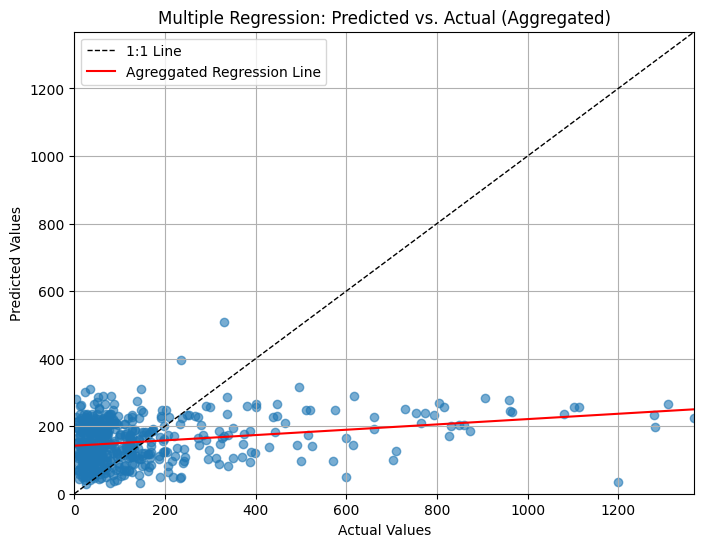

In [10]:
# Calculate the averaged predictions and collect the target values
averaged_predictions = []
actual_values = []

for idx, preds in predictions.items():
    averaged_predictions.append(np.mean(preds))
    actual_values.append(df.iloc[idx][target])

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, averaged_predictions, alpha=0.6)

# Add the 1:1 line for reference
max_val = max(max(actual_values), max(averaged_predictions))
plt.plot([0, max_val], [0, max_val], 'k--', linewidth=1, label='1:1 Line')

# Add the regression line for the aggregated results
z = np.polyfit(actual_values, averaged_predictions, 1)
p = np.poly1d(z)
x_for_line = np.linspace(0, max_val, 100)
plt.plot(x_for_line, p(x_for_line), "r-", label=f'Agreggated Regression Line')

# Set plot labels and title
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Multiple Regression: Predicted vs. Actual (Aggregated)")
plt.legend()
plt.grid(True)
plt.show()